In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError

import torch
import torchvision.transforms as T
import torchvision.models as models

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [5]:
DATASET_PATH = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"

classes = sorted([
    cls for cls in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, cls))
])

SAMPLES_PER_CLASS = 50

image_paths = []
labels = []

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    images = os.listdir(cls_path)
    sampled = random.sample(images, min(SAMPLES_PER_CLASS, len(images)))
    for img in sampled:
        image_paths.append(os.path.join(cls_path, img))
        labels.append(cls)

print(f"Total sampled images: {len(image_paths)}")


Total sampled images: 400


In [6]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [8]:
from torchvision.models import ResNet18_Weights, ViT_B_16_Weights

# ResNet18
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = torch.nn.Identity()
resnet.eval()

# Vision Transformer
vit = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit.heads = torch.nn.Identity()
vit.eval()


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [9]:
resnet_embeddings = []
valid_labels = []
skipped = 0

with torch.no_grad():
    for p, lbl in zip(image_paths, labels):
        try:
            img = Image.open(p).convert("RGB")
            img = transform(img).unsqueeze(0)
            emb = resnet(img).squeeze().numpy()
            resnet_embeddings.append(emb)
            valid_labels.append(lbl)
        except (UnidentifiedImageError, OSError):
            skipped += 1

resnet_embeddings = np.array(resnet_embeddings)
print(f"ResNet: skipped {skipped} unreadable images")


ResNet: skipped 26 unreadable images


In [10]:
vit_embeddings = []
skipped_vit = 0

with torch.no_grad():
    for p, lbl in zip(image_paths, labels):
        try:
            img = Image.open(p).convert("RGB")
            img = transform(img).unsqueeze(0)
            emb = vit(img).squeeze().numpy()
            vit_embeddings.append(emb)
        except (UnidentifiedImageError, OSError):
            skipped_vit += 1

vit_embeddings = np.array(vit_embeddings)
print(f"ViT: skipped {skipped_vit} unreadable images")


ViT: skipped 26 unreadable images


In [11]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(valid_labels)


In [12]:
def plot_pca(embeddings, labels, title, dim=2):
    pca = PCA(n_components=dim)
    reduced = pca.fit_transform(embeddings)

    if dim == 2:
        plt.figure(figsize=(7, 6))
        plt.scatter(
            reduced[:, 0], reduced[:, 1],
            c=labels, cmap="tab10", alpha=0.7
        )
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title(title)
        plt.colorbar()
        plt.show()

    elif dim == 3:
        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            reduced[:, 0], reduced[:, 1], reduced[:, 2],
            c=labels, cmap="tab10", alpha=0.7
        )
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(title)
        plt.show()


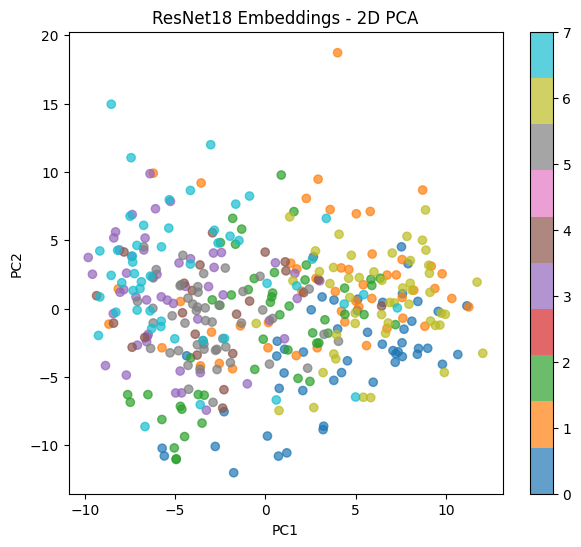

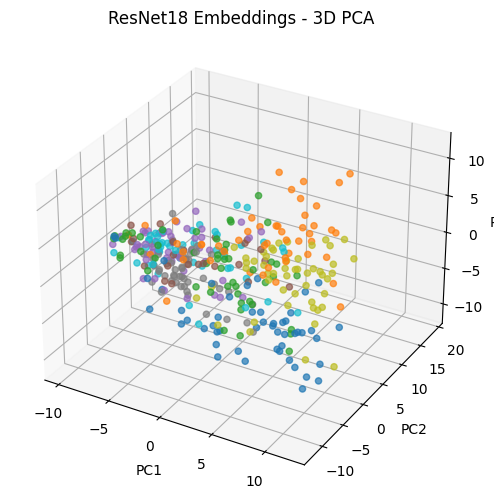

In [13]:
plot_pca(resnet_embeddings, encoded_labels,
         "ResNet18 Embeddings - 2D PCA", dim=2)

plot_pca(resnet_embeddings, encoded_labels,
         "ResNet18 Embeddings - 3D PCA", dim=3)


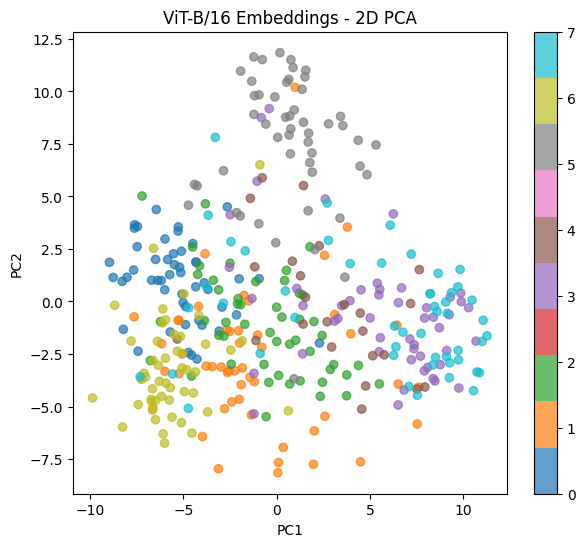

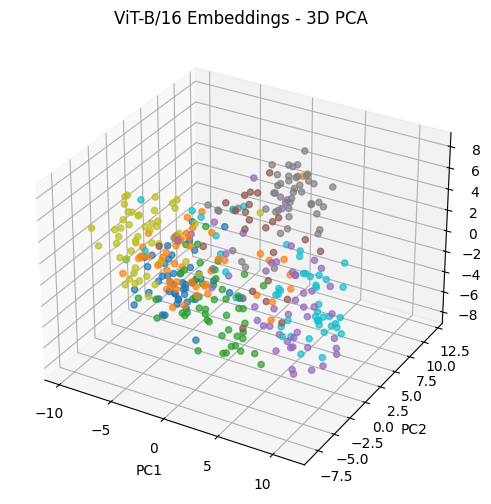

In [14]:
plot_pca(vit_embeddings[:len(encoded_labels)], encoded_labels,
         "ViT-B/16 Embeddings - 2D PCA", dim=2)

plot_pca(vit_embeddings[:len(encoded_labels)], encoded_labels,
         "ViT-B/16 Embeddings - 3D PCA", dim=3)
